# Installing & imports

For Google Colab Only:

In [1]:
# from google.colab import drive
import pandas as pd
import numpy as np
import pickle

# drive.mount('/content/drive')

In [ ]:
%pip install seaborn spacy ekphrasis wordcloud emojis contractions scikit-learn nltk neo4j

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.tree import DecisionTreeClassifier
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.stem import LancasterStemmer
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from nltk.corpus import wordnet
from wordcloud import WordCloud
import seaborn as sns
import time as timer
import contractions
import pandas as pd
import numpy as np
import warnings
import pickle
import emojis
import spacy
import nltk
import re

# Turn off all warnings
warnings.filterwarnings("ignore")

nltk.download(['punkt','wordnet','stopwords','sentiwordnet','averaged_perceptron_tagger', 'vader_lexicon'])
stop_words = set(stopwords.words('english'))

porter = stemmer = PorterStemmer()
lancaster=LancasterStemmer()

# EDA (Exploratory Data Analysis)


Twitter sentiment140 dataset

In [ ]:
df = pd.read_csv('./datasets/training.1600000.processed.noemoticon.csv', encoding='latin-1')

DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
df.columns = DATASET_COLUMNS
df.head()

target         ids                          date      flag           user  \
0       0  1467810672  Mon Apr 06 22:19:49 PDT 2009  NO_QUERY  scotthamilton   
1       0  1467810917  Mon Apr 06 22:19:53 PDT 2009  NO_QUERY       mattycus   
2       0  1467811184  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY        ElleCTF   
3       0  1467811193  Mon Apr 06 22:19:57 PDT 2009  NO_QUERY         Karoli   
4       0  1467811372  Mon Apr 06 22:20:00 PDT 2009  NO_QUERY       joy_wolf   

                                                text  
0  is upset that he can't update his Facebook by ...  
1  @Kenichan I dived many times for the ball. Man...  
2    my whole body feels itchy and like its on fire   
3  @nationwideclass no, it's not behaving at all....  
4                      @Kwesidei not the whole crew

In [ ]:
df.user.describe()

count      1599999
unique      659775
top       lost_dog
freq           549
Name: user, dtype: object

Reddit Suicide Detection dataset

In [ ]:
df2 = pd.read_csv("./datasets/Suicide_Detection.csv")

df2['class'] = df2['class'].apply(lambda cls: 1 if cls =='suicide' else 0)
df2 = df2.rename({'class': 'depressed'}, axis=1)

del df2['Unnamed: 0']

print(df2.shape)
print(df2.depressed.value_counts())
df2.head()

(232074, 2)
1    116037
0    116037
Name: depressed, dtype: int64


text  depressed
0  Ex Wife Threatening SuicideRecently I left my ...          1
1  Am I weird I don't get affected by compliments...          0
2  Finally 2020 is almost over... So I can never ...          0
3          i need helpjust help me im crying so hard          1
4  I’m so lostHello, my name is Adam (16) and I’v...          1

Second dataset is not useful as there is no information about the author (user who posted the content) of the posts.

# Custom Extraction Functions


Lexicon creation

In [ ]:
# reference: https://www.nature.com/articles/s41599-022-01313-2

mental_heath_lex = ["anxiety", "insomnia", "suicidal", "dysfunction", "fatigue", "imbalance", "nervousness", "sad",
"lonely", "unhappy", "no focus", "disturbed", "isolation", "lack of interest", "low interaction", "sleep problems",
"loss of meaning in life", "stressed", "uneasiness", "instability", "moody", "emotional", "low self-esteem",
"have no emotional support", "depressed", "depression", "suicide", "broken", "killme", "worthless", "selfharmmm", "pain"]

Junyeop_lexicon = {"Junyeop_lexicon": mental_heath_lex}

In [ ]:
major = ['sleep', 'doled', 'dolorous', 'sad', 'disorder', 'misery', 'unable', 'unhappy', 'dispirited', 'dog', 'moped', 'ache', 'economic', 'memory', 'moody', 'hopeless', 'loss', 'dimple',
'blah', 'overeat', 'funky', 'interest', 'concentrate', 'schizophrenia', 'clinical', 'lonely', 'dump', 'slump', 'worthless', 'gloomy', 'oppressive', 'tear', 'pain', 'insomnia', 'megrim', 'decision',
'pessimistic', 'upset', 'desolate', 'dysthymia', 'black', 'doldrum', 'depressed', 'low spirit', 'difficult', 'dejected', 'despondent', 'pleasure', 'sinkhole', 'alcohol', 'suicide', 'appetite',
'feel', 'impressed', 'morose', 'melancholia', 'endogenous', 'grief', 'dementia', 'death', 'despair', 'gloomy', 'psychosis', 'woe', 'unexplained', 'imprint', 'worry', 'melancholy', 'much', 'self-harm',
'postnatal', 'thought', 'active', 'dysphoria', 'downhearted', 'slough', 'blue', 'affect', 'problem', 'anxiety', 'discouraged', 'sorrow', 'heavy-hearted', 'crisis', 'reactive', 'lack', 'low', 'constant']

persistent = ['deep', 'sad', 'hopeless', 'low', 'feeling', 'inadequacy', 'self', 'esteem', 'energy', 'pattern', 'function', 'unable', 'even', 'social', 'withdrawn']

perinatal = ['sad', 'anxiety', 'anger', 'rage', 'exhausted', 'extreme', 'worry', 'baby', 'health', 'difficulty', 'care', 'self', 'harm']

seasonal = ['season', 'depressed', 'social', 'withdrawn', 'increased', 'need', 'sleep', 'weight', 'gain', 'daily', 'feeling', 'sad', 'hopeless', 'unworthy']

situational = ['situation', 'depressed', 'death', 'love', 'serious', 'ill', 'life', 'threatening', 'event', 'divorce', 'child', 'custody', 'issue', 'be', 'emotional',
'physical', 'abuse', 'relationship', 'unemployment', 'face', 'financial', 'difficulty', 'extensive', 'legal', 'trouble', 'frequent', 'cry', 'sad', 'hopeless', 'anxiety', 'pain', 'ache', 'fatigue', 'unable', 'withdrawn']

atypical = ['atypical', 'depressed', 'increased', 'appetite', 'weight', 'gain', 'disorder', 'eating', 'poor', 'body', 'sleep', 'insomnia', 'heavy', 'rejection', 'sensitive', 'critic', 'assorted', 'ache', 'pain']

premenstrual_dsyphoric = ['cramp', 'bloating', 'breast', 'tender', 'headache', 'joint', 'muscle', 'pain', 'sad', 'despair', 'irritated', 'anger', 'mood', 'swing', 'food', 'craving', 'binge', 'eating', 'panic',
'attack', 'anxiety', 'lack', 'energy', 'trouble', 'focusing', 'sleep', 'problem']

bipolar = ['feeling', 'sad', 'empty', 'lack', 'energy', 'fatigue', 'sleep', 'problem', 'trouble', 'decreased', 'loss', 'suicidal', 'thought', 'high', 'energy', 'reduced', 'irritated', 'racing', 'speech',
'grandiose', 'thinking', 'increased', 'self', 'esteem', 'confidence', 'unusual', 'risky', 'destructive', 'behavior', 'elated', 'euphoria']

anxiety = ['fear', 'angst', 'anxious', 'nervous', 'uneasi', 'concern', 'panic', 'insecur', 'emot', 'worri', 'disquietud', 'hypochondria', 'disquiet', 'anger', 'restless', 'discomfort', 'distress', 'social', 'neurotic', 'qualm', 'discomfitur', 'troubl', 'care', 'discomposur', 'psycholog', 'state', 'scare', 'scrupl', 'nervou', 'headach', 'jitteri', 'neurosi', 'headach', 'stress', 'pain', 'paranoia', 'trepid', 'frustrat']

anxious_depression = ['fat', 'bad', 'weak', 'problem', 'tired', 'illusion', 'restless', 'bored', 'crap', 'shit', 'fuck', 'sad', 'escape', 'useless', 'meaningless', 'cry', 'rejected', 'suffering', 'sleepless', 'never', 'bored', 'afraid', 'unhappy', 'ugly', 'upset', 'awe', 'torture', 'unsuccessful', 'helpless', 'suffering', 'fail', 'sorrow', 'nobody', 'blame', 'damaged', 'shattered', 'pathetic', 'insomnia', 'kill', 'panic', 'lonely', 'hate', 'depressed', 'frustrated', 'loser', 'suicidal', 'hurt', 'pain', 'disappointment', 'broke', 'abandoned', 'worthless', 'regret', 'dissatisfied', 'lost', 'empty', 'destroyed', 'ruined', 'die', 'sick']

In [ ]:
lexicon_dir = './utils/lexicon.pkl'
lexicon = {}

with open(lexicon_dir, 'rb') as f:
  lexicon = pickle.load(f)

In [ ]:
for key, value in lexicon.items():
  print(key, value)

major ['sleep', 'dole', 'dolor', 'sad', 'disord', 'miseri', 'inabl', 'unhappi', 'dispirited', 'dog', 'mope', 'ach', 'econom', 'memori', 'moodi', 'hopeless', 'loss', 'dimpl', 'blah', 'overeat', 'funk', 'interest', 'concentr', 'schizophrenia', 'clinic', 'loneli', 'dump', 'slump', 'worthless', 'gloom', 'oppress', 'tear', 'pain', 'insomnia', 'megrim', 'decis', 'pessim', 'upset', 'desol', 'dysthymia', 'black', 'doldrum', 'depress', 'low spirit', 'difficult', 'deject', 'despond', 'pleasur', 'sinkhol', 'alcohol', 'suicid', 'appetit', 'feel', 'impress', 'moros', 'melancholia', 'endogen', 'grief', 'dementia', 'death', 'despair', 'gloomi', 'psychosi', 'woe', 'unexplain', 'imprint', 'worri', 'melancholi', 'much', 'self-harm', 'postnat', 'thought', 'activ', 'dysphoria', 'downhearted', 'slough ', 'blue', 'affect', 'problem', 'anxieti', 'discourag', 'sorrow', 'heavy-hearted', 'crisi', 'reactiv', 'lack', 'low', 'constant']
persistent ['deep', 'sad', 'hopeless', 'low', 'feel', 'inadequaci', 'self', 'e

In [ ]:
from nltk.stem import PorterStemmer
stemmer = PorterStemmer()

def related_word_features_extraction(df, text_feat):
  for key in lexicon:
    words = set(lexicon[key])
    df[key] = df[text_feat].apply(lambda t: len(set(word for word in nltk.word_tokenize(t)).intersection(words)))

loading slangs


In [ ]:
with open('./utils/slangs.pkl', 'rb') as f:
    slangs = pickle.load(f)

print(len(slangs))

60


In [ ]:
from nltk.tokenize import RegexpTokenizer

def get_wordnet_pos(word):
    """Map POS tag to first character lemmatize() accepts"""
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

# Init Lemmatizer
lemmatizer = WordNetLemmatizer()

def lemmatize_text(text):
    return ' '.join([lemmatizer.lemmatize(w, get_wordnet_pos(w)) for w in word_tokenize(text)])

def handle_negations(text):
    transformed = re.sub(r'\b(?:not|isn\'t|doesn\'t|can\'t|couldn\'t|won\'t)\b[\w\s]+[^\w\s]',
        lambda match: re.sub(r'(\s+)(\w+)', r'\1NOT_\2', match.group(0)),
        text,
        flags=re.IGNORECASE)
    return transformed

In [ ]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
        'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
        'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens

    segmenter="twitter",
    corrector="twitter",

    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=False,  # spell correction for elongated words

    tokenizer=SocialTokenizer(lowercase=True).tokenize,

    dicts=[emoticons]
)

def textPreProcessingPhase1(text):

  # Emoji parsing
  text = emojis.decode(str(text))

  # Slang parsing
  for slang, meaning in slangs.items():
    text = text.replace(slang, meaning)

  text = " ".join(text_processor.pre_process_doc(text))
  text = re.sub(r'<.*?>', '', text)   # annotations removal
  text = ' '.join(re.findall(r'\w+', text))   # Special characters removal
  text = re.sub(r'\@[A-Za-z0-9_]+','',text)   # twitter handlers removal. Notice that you need to escape @ symbol.
  text = re.sub(r'[^\x00-\x7F]+', '', text)   # non-English characters removal
  text = re.sub(r'\d+', '', text)   # removal of all numbers
  text = re.sub(r'(?<=\s)[a-zA-Z](?=\s)', '', text)   # single characters removal but not at the beginning or end of words
  text = re.sub(r'\s+', ' ', text, flags=re.I)    # multiple spaces removal

  # Handle Negations
  text = handle_negations(text)

  # Apply Lemmatization
  text = lemmatize_text(text)

  important_words = ['not', 'no', 'never', 'neither', 'nor', 'very', 'too', 'so', 'more', 'most', 'less', 'least']
  my_stop_words = stop_words - set(important_words)

  # # Remove stop words
  text = ' '.join([word for word in text.split() if word.lower() not in my_stop_words])

  return text

Reading twitter - 1grams ...
Reading twitter - 2grams ...
Reading twitter - 1grams ...


In [ ]:
sentences = [
    "https://github.com/cbaziotis/ekphrasis CANT WAIT for the new season of #TwinPeaks ＼(^o^)／!!! #davidlynch #tvseries 😊 :)))",
    "@SentimentSymp:  can't wait for the Nov 9 #Sentiment talks!  YAAAAAAY !!! :-D http://sentimentsymposium.com/.",
    " I don't feel good B4 U arrive 🚶! I won't look at you",
    "B4 U left 🚶,i was full of motivation in my life, and now I am empty of everything. THX 😊.",
    "This must not b3 delet3d, but the number at the end yes 134411",
    "I am not good",
    "unhappy",
    "I am",
    "You won't understand how much I love pizza."
]

for s in sentences:
  text = textPreProcessingPhase1(s)
  print('cleaned_text:',text)

cleaned_text: cant wait new season twin peak david lynch tv series blush
cleaned_text: not wait sentiment talk yay
cleaned_text: not feel good befor arrive walk not look
cleaned_text: befor left walk full motivation life empty everything thank blush
cleaned_text: must not deletd number end yes
cleaned_text: not good
cleaned_text: unhappy
cleaned_text: 
cleaned_text: not understand much love pizza


Temporal feature

In [ ]:
from datetime import time
import dateutil.parser

# Function to check if time is between 1 am and 6 am
def check_time_range(date_string):

    # Define timezone info for PDT
    tzinfos = {"PDT": -7 * 60 * 60}

    # Parse the date string using dateutil.parser.parse() with tzinfos argument
    date = dateutil.parser.parse(date_string, tzinfos=tzinfos)

    # Extract the time portion
    time_val = date.time()

    # Check if the time is between 1 am and 6 am
    if time(1, 0) <= time_val <= time(6, 0):
        return 1
    else:
        return 0

def temporal_features_extraction(df,time_feat):
    # Apply the function on the 'date' column and create a new column 'is_1_to_6'
    df.loc[:, 'isLateNight'] = df[time_feat].apply(check_time_range)


Sentiment Analyzer

In [ ]:
analyzor = SentimentIntensityAnalyzer()

def analyze(text):
  extended = contractions.fix(text)
  scores = analyzor.polarity_scores(extended)
  return list(scores.values())

def sentiment_analysis(df,text_feat):
  df['neg'], df['neu'],df['pos'], df['compound'] = zip(*df[text_feat].apply(analyze))


def get_avg_sent_score(word_list):
  sent_score = []
  for word in word_list:
      polarity = analyzor.polarity_scores(word)
      sent_score.append((polarity["compound"]))

  if len(sent_score) ==0:
    print(word_list)

  avg_sent_score = sum(sent_score) / len(sent_score)
  return avg_sent_score

In [ ]:
words = ['ily', 'love', 'best', 'awesome', 'lmao', 'win', 'rofl', 'happy', 'laugh', 'hahaha', 'yay', 'kind', 'congrats', 'yummy', 'fun', 'free', 'talented', 'kudos', 'friend', 'save']
get_avg_sent_score(words)

0.5569650000000002

In [ ]:
neg = get_avg_sent_score(['bad', 'horrible', 'worst', 'good', 'best', 'amazing'])
neg

-0.0077166666666666495

In [ ]:
col1 = ["i don't feel good",
        "i saw the new john doe movie and it sucks waisted bad movies"]

df = pd.DataFrame({'col1': col1 })

df['col1'] = df["col1"].apply(lambda text:textPreProcessingPhase1(text))

sentiment_analysis(df,'col1')

df.head()

col1    neg    neu  pos  compound
0                                  not feel good  0.546  0.454  0.0   -0.3412
1  saw new john doe movie suck waisted bad movie  0.478  0.522  0.0   -0.7506

# Feature Extraction


In [ ]:
def feature_extraction(df,text_feat,time_feat):

  df['cleaned_txt'] = df[text_feat].apply(lambda text:textPreProcessingPhase1(text))

  print((df['cleaned_txt'] == "").sum(),"records with no text have droped.")

  df.drop(df[df['cleaned_txt'] == ""].index, inplace=True)

  related_word_features_extraction(df, 'cleaned_txt')

  if time_feat != None:
    temporal_features_extraction(df, time_feat)

New user based selection approach


In [ ]:
df = pd.read_csv('./datasets/training.1600000.processed.noemoticon.csv', encoding='latin-1')
DATASET_COLUMNS = ["target", "ids", "date", "flag", "user", "text"]
df.columns = DATASET_COLUMNS

print("Dataset shape:", df.shape)
print("Total number of unique users: ", len(df.user.unique()))

Dataset shape: (1599999, 6)
Total number of unique users:  659775


In [ ]:
by_user = df.groupby('user')

# Sort users by the number of their records in descending order
user_group_sorted = by_user.size().sort_values(ascending=False)

# Filter to select users that have at least 10 records
user_group_filtered = user_group_sorted[user_group_sorted >= 10]

# Create a list of users
top_users = user_group_filtered.index.tolist()

Considering only tweets from top users.

In [ ]:
df = df[df.user.isin(top_users)]
print("data shape:", df.shape)
print("Total number of unique users: ", len(df.user.unique()))

data shape: (430677, 6)
Total number of unique users:  21875


4    241676
0    189001
Name: target, dtype: int64


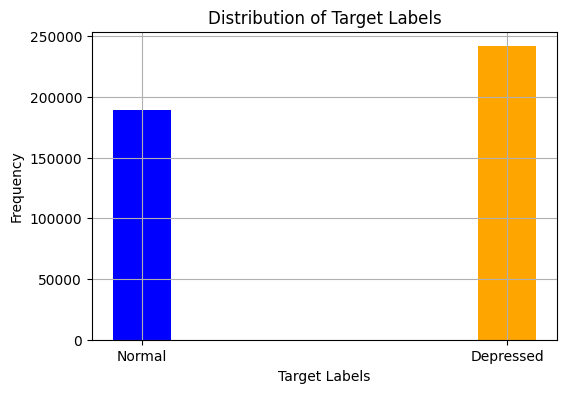

In [ ]:
import matplotlib.pyplot as plt

# Customize the plot
plt.figure(figsize=(6, 4))  # Set the figure size
plt.title("Distribution of Target Labels")  # Set the title for the plot

# Set the color for each bar
color_map = {0: 'blue', 4: 'orange'}  # Assuming 0 represents "normal" and 1 represents "depressed"

# Count the frequency of each label
label_counts = df['target'].value_counts()

print(label_counts)

# Plot the histogram bars with customized colors and width
bar_width = 0.63  # Adjust the width as desired
plt.bar(label_counts.index, label_counts.values, color=[color_map[label] for label in label_counts.index], width=bar_width)

# Set the x-axis labels
plt.xticks([0, 4], ['Normal', 'Depressed'])  # Assuming 0 represents "normal" and 1 represents "depressed"

# Add labels to the axes
plt.xlabel("Target Labels")
plt.ylabel("Frequency")

# Add a grid
plt.grid(True)

plt.savefig("Analetic results/target_dist_before.pdf", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
df.shape[0] * 0.05

21533.850000000002

In [ ]:
%%time
# define the threshold for acceptable size difference
THRESHOLD = df.shape[0] * 0.05  # 10 percent size difference

print("threshould:", THRESHOLD)

# count the number of records for each class
class_counts = df['target'].value_counts()

# identify the class with fewer records
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()

# calculate current difference
current_diff = class_counts[majority_class] - class_counts[minority_class]

print("current diff:", current_diff)

# get a list of users already in the df (top_users)
existing_users = df['user'].unique()

# get remaining users from the original dataframe
remaining_users = by_user.filter(lambda x: x.name not in existing_users)

# find users with most tweets from the minority class
user_minority_class_size = remaining_users[remaining_users['target'] == minority_class].groupby('user').size()
sorted_minority_users = user_minority_class_size.sort_values(ascending=False)

for user in sorted_minority_users.index:
    print(current_diff)
    # break the loop if current difference is less than or equal to the threshold
    if current_diff <= THRESHOLD:
        break

    user_tweets = remaining_users[remaining_users['user'] == user]
    df = pd.concat([df, user_tweets])

    # recalculate the difference
    class_counts = df['target'].value_counts()
    current_diff = class_counts[majority_class] - class_counts[minority_class]


threshould: 21533.850000000002
current diff: 52675
52675
52666
52657
52648
52639
52630
52621
52612
52603
52594
52585
52576
52567
52558
52549
52540
52531
52522
52513
52504
52495
52486
52477
52468
52459
52450
52441
52432
52423
52414
52405
52396
52387
52378
52369
52360
52351
52342
52333
52324
52315
52306
52297
52288
52279
52270
52261
52252
52243
52234
52225
52216
52207
52198
52189
52180
52171
52162
52153
52144
52135
52126
52117
52108
52099
52090
52081
52072
52063
52054
52045
52036
52027
52018
52009
52000
51991
51982
51973
51964
51955
51946
51937
51928
51919
51910
51901
51892
51883
51874
51865
51856
51847
51838
51829
51820
51811
51802
51793
51784
51775
51766
51757
51748
51739
51730
51721
51712
51703
51694
51685
51676
51667
51658
51649
51640
51631
51622
51613
51604
51595
51586
51577
51568
51559
51550
51541
51532
51523
51514
51505
51496
51487
51478
51469
51460
51451
51442
51433
51424
51415
51406
51397
51388
51379
51370
51361
51352
51343
51334
51325
51316
51307
51298
51289
51280
51271
51262
5

In [ ]:
import time as timer

df.drop(["ids", "flag"], axis = 1, inplace = True)

# Map the values
df.loc[df['target'] == 0, 'target'] = 0
df.loc[df['target'] == 4, 'target'] = 1

start = timer.time()

feature_extraction(df,'text','date')
df.head(2)

print("\nFeature extraction time:", round(timer.time() - start,2),'sec')

2259 records with no text have droped.

Feature extraction time: 977.39 sec


In [ ]:
print("data shape:", df.shape)
print("Total number of unique users: ", len(df.user.unique()))

data shape: (468272, 17)
Total number of unique users:  27069


1    244720
0    223552
Name: target, dtype: int64


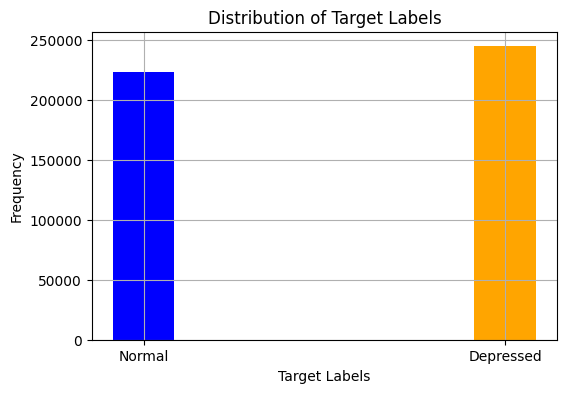

In [ ]:
import matplotlib.pyplot as plt

# Customize the plot
plt.figure(figsize=(6, 4))  # Set the figure size
plt.title("Distribution of Target Labels")  # Set the title for the plot

# Set the color for each bar
color_map = {0: 'blue', 1: 'orange'}  # Assuming 0 represents "normal" and 1 represents "depressed"

# Count the frequency of each label
label_counts = df['target'].value_counts()

print(label_counts)

# Plot the histogram bars with customized colors and width
bar_width = 0.17  # Adjust the width as desired
plt.bar(label_counts.index, label_counts.values, color=[color_map[label] for label in label_counts.index], width=bar_width)

# Set the x-axis labels
plt.xticks([0, 1], ['Normal', 'Depressed'])  # Assuming 0 represents "normal" and 1 represents "depressed"

# Add labels to the axes
plt.xlabel("Target Labels")
plt.ylabel("Frequency")

# Add a grid
plt.grid(True)

plt.savefig("Analetic results/target_dist_after.pdf", bbox_inches='tight')

# Show the plot
plt.show()

In [ ]:
df.columns[:30]

Index(['target', 'date', 'user', 'text', 'cleaned_txt', 'major', 'persistent',
       'perinatal', 'seasonal', 'situational', 'atypical', 'Junyeop_lexicon',
       'premenstrual_dsyphoric', 'bipolar', 'anxiety', 'anxious_depression',
       'isLateNight'],
      dtype='object')

<Figure size 1400x1200 with 0 Axes>

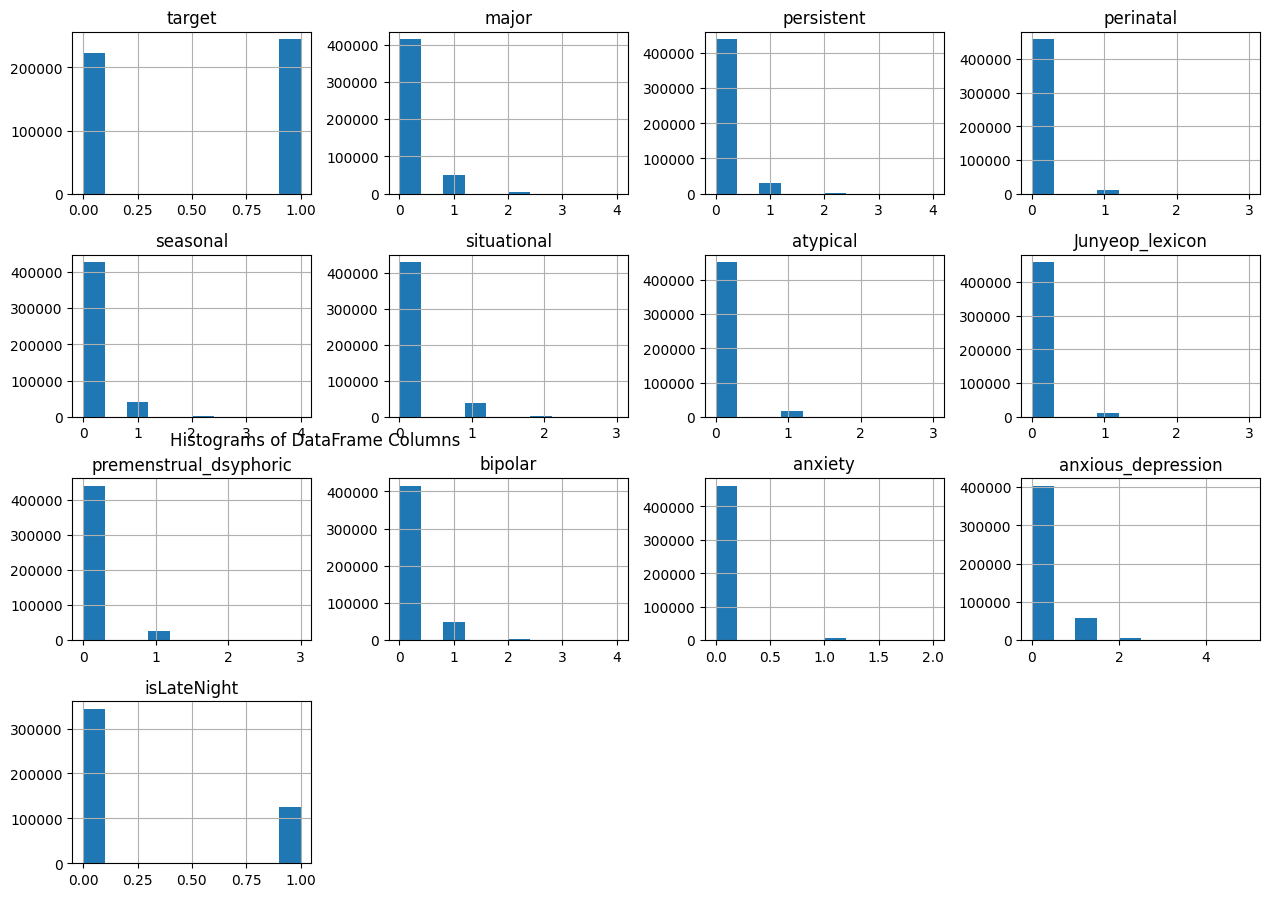

In [ ]:
plt.figure(figsize=(14, 12))

# Generate histograms for all columns
df.hist()

# Set plot title and axis labels
plt.suptitle('Histograms of DataFrame Columns')
plt.tight_layout(rect=[0, 0, 2, 1.96])
plt.show()

Saving the pre-processed dataset

In [ ]:
# save data frame
path = './pre-processed data/cleaned_big_sentiment140_full_lex.csv'
df.to_csv(path, encoding='latin-1', index= False)

print("Data shape:", df.shape)

Data shape: (468272, 17)


# Data Profiling

In [ ]:
# %pip install neo4j yfiles_jupyter_graphs graphdatascience

In [ ]:
df2 = pd.read_csv("pre-processed data/cleaned_big_sentiment140_full_lex.csv", encoding='latin-1')
print("Number of NaNs in each column:\n",df2.isna().sum())
print("Data shape:", df2.shape)

Number of NaNs in each column:
 target                    0
date                      0
user                      0
text                      0
cleaned_txt               0
major                     0
persistent                0
perinatal                 0
seasonal                  0
situational               0
atypical                  0
Junyeop_lexicon           0
premenstrual_dsyphoric    0
bipolar                   0
anxiety                   0
anxious_depression        0
isLateNight               0
dtype: int64
Data shape: (468272, 17)


In [ ]:
df2.persistent.describe()

count    468272.000000
mean          0.066177
std           0.257695
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           4.000000
Name: persistent, dtype: float64

In [ ]:
df2[['cleaned_txt', 'user']].head(10)

cleaned_txt            user
0                    whole body feel itchy like fire         ElleCTF
1                        no not behaving mad not see          Karoli
2  loudtrish hey long time no see yes rain bit bi...            coZZ
3                       wish get watch miss premiere      HairByJess
4  hollis death scene hurt severely watch film wr...  lovesongwriter
5       ahh ive always want see rent love soundtrack      starkissed
6             oh dear drinking forgotten table drink       gi_gi_bee
7                          cry asian eye sleep night            jsoo
8  really not feel like get today get study tomor...      itsanimesh
9  sad sad sad not know hate feel wan na sleep st...       kennypham

<Axes: >

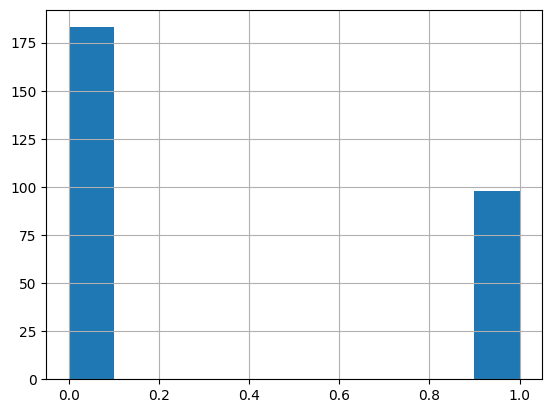

In [ ]:
df2[df2.user == "SallytheShizzle"].target.hist()

In [ ]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
username = "neo4j"
password = "profiling168421"
db_name = "mental"
driver = GraphDatabase.driver(uri, auth=(username, password), database= db_name)

In [ ]:
u_list = ['lost_dog',
 'webwoke',
 'tweetpet',
 'SallytheShizzle',
 'VioletsCRUK',
 'mcraddictal',
 'tsarnick',
 'what_bugs_u']

properties = ['name', 'avg_major','avg_persistent','avg_perinatal', 'avg_seasonal','avg_situational','avg_atypical', 'avg_jun_lex','avg_pmd','avg_bipolar', 'avg_anxiety','avg_anx_dep'
]
# Generate the property string by joining the properties with a comma
property_string = ', '.join(['u.' + prop for prop in properties])

In [ ]:
from yfiles_jupyter_graphs import GraphWidget

driver = GraphDatabase.driver(uri, auth=(username, password), database= db_name)
session = driver.session()

result = session.run("MATCH (u:User{name:'18percentgrey'})-[r:POSTED]->(t:Tweet) RETURN u, r, t LIMIT 30;")

# Plotting the dataset
graph = result.graph()
plot = GraphWidget(graph = graph)
plot.show()

session.close()
driver.close()

GraphWidget(layout=Layout(height='500px', width='100%'))

### User profiling

In [ ]:
# grouping by user
user_grouped = df2.groupby("user")

# checking one of the groups for reviewing
user_grouped.get_group("Spidersamm").head(2)

target                          date        user  \
10123       0  Sat May 02 06:46:50 PDT 2009  Spidersamm   
12282       0  Sun May 03 04:27:55 PDT 2009  Spidersamm   

                                                    text  \
10123  i didnt get to meet bradie tonight, he was to ...   
12282  @shaundiviney Shaun  this announcement better ...   

                                             cleaned_txt  major  persistent  \
10123           didnt get meet bradie tonight sooky come      0           0   
12282  shaun announcement well worth andy say make bi...      0           0   

       perinatal  seasonal  situational  atypical  Junyeop_lexicon  \
10123          0         0            0         0                0   
12282          0         0            0         0                0   

       premenstrual_dsyphoric  bipolar  anxiety  anxious_depression  \
10123                       0        0        0                   0   
12282                       0        0        0                   0   

       isLateNight  
10123            0  
12282            1

In [ ]:
sid = SentimentIntensityAnalyzer()
sid.polarity_scores("postcode")

{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}

Finding the most used keywords per user.

In [ ]:
from collections import Counter
import re
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

top_keywords_per_user = []
sid = SentimentIntensityAnalyzer()
ignore_words = {'tweet', 'twitter'}

for user, group in user_grouped:
    words = re.sub(r'not (\w+)', r'not_\1', ' '.join(group["cleaned_txt"])).lower().split()
    words = [word for word in words if len(word) > 1 and word not in ignore_words]  # Ignore specific words

    word_sentiments = {word: sid.polarity_scores(word)['compound'] for word in words}

    # Sort by frequency and select top 20 with non-zero sentiment score
    top_20_keywords = sorted(word_sentiments.items(), key=lambda x: x[1], reverse=True)[:20]

    # Keep only the words
    res = [word for word, count in top_20_keywords]
    if len(res) == 0:
        print(res, words,"\n")

    top_keywords_per_user.append({'user': user, 'top_words': res})

user_keywords_df = pd.DataFrame(top_keywords_per_user)
print(user_keywords_df.isna().sum())
user_keywords_df.head(4)


user         0
top_words    0
dtype: int64


user                                          top_words
0        007peter  [love, glee, adoration, happy, praise, beloved...
1         0ilyct0  [love, woo, haha, like, yeah, woke, minute, ag...
2  0mgITSkathleen  [help, not_wan, na, go, skool, take, final, ch...
3  0summerbreeze0  [great, happy, hope, hopefully, yes, cool, wel...

In [ ]:
user_keywords_df.isna().sum()

user         0
top_words    0
dtype: int64

In [ ]:
user_keywords_df[user_keywords_df.user == "SallytheShizzle"].head(2)

user                                          top_words
8095  SallytheShizzle  [ily, love, best, awesome, lmao, win, rofl, ha...

In [ ]:
words = user_keywords_df[user_keywords_df.user == "SallytheShizzle"].top_words.values
print(words[:30])

[list(['ily', 'love', 'best', 'awesome', 'lmao', 'win', 'rofl', 'happy', 'laugh', 'hahaha', 'yay', 'kind', 'congrats', 'yummy', 'fun', 'free', 'talented', 'kudos', 'friend', 'save'])]


In [ ]:
round(get_avg_sent_score(['ily', 'love', 'best', 'awesome', 'lmao', 'win', 'rofl', 'happy', 'laugh', 'hahaha', 'yay', 'kind', 'congrats', 'yummy', 'fun', 'free', 'talented', 'kudos', 'friend', 'save']),4)

0.557

In [ ]:
user_counts = df2.groupby('user').size().sort_values(ascending=False)
user_list = user_counts.index.tolist()
user_list[:10]

['lost_dog',
 'webwoke',
 'tweetpet',
 'SallytheShizzle',
 'VioletsCRUK',
 'mcraddictal',
 'tsarnick',
 'what_bugs_u',
 'Karen230683',
 'DarkPiano']

In [ ]:
df2.columns[:40]

Index(['target', 'date', 'user', 'text', 'cleaned_txt', 'major', 'persistent',
       'perinatal', 'seasonal', 'situational', 'atypical', 'Junyeop_lexicon',
       'premenstrual_dsyphoric', 'bipolar', 'anxiety', 'anxious_depression',
       'isLateNight'],
      dtype='object')

In [ ]:
tweet_prof_cols = ['user', 'text', 'major', 'persistent', 'perinatal', 'seasonal', 'situational',
       'atypical', 'Junyeop_lexicon', 'premenstrual_dsyphoric', 'bipolar',
       'anxiety', 'anxious_depression', 'isLateNight']

In [ ]:
%%time

session = driver.session()

## Deleting all the previous records
session.run("MATCH (n) DETACH DELETE n")
total_size = len(user_list)
for i, user in enumerate(user_list):

  # print(f"Profiling user {i+1} of {TOTAL_USERS}", f"({((i+1) / TOTAL_USERS * 100):.2f}%)")
  print(f"Profiling user {i} of {total_size}", f"({(i/total_size) * 100:.2f}%)")

  user_df = user_grouped.get_group(user)

  for ind, row in user_df.iterrows():

    # Assuming `row` contains a single row of data from your dataset
    property_setters = ', '.join([f"t.{col} = ${col}" for col in tweet_prof_cols])
    query2 = f""" CREATE (t:Tweet) SET {property_setters}"""

    session.run(query2, **row)

  # Get the user's top keywords
  top_used_words = user_keywords_df.loc[user_keywords_df['user'] == user, 'top_words'].values[0]
  if len(top_used_words) == 0:
    print(user)

  avg_top_sent = round(get_avg_sent_score(top_used_words),2)
  if (avg_top_sent == None):

    print(f'For user {user}, top words sentiment: {avg_top_sent}, top words: {top_used_words}')


  # Inserting the user info
  user_data = {"name": user, "top_used_words": top_used_words, "avg_top_sent": avg_top_sent}

  query = """
  CREATE (n:User { name: $name, top_used_words: $top_used_words, avg_top_sent: $avg_top_sent,
  nightTweetsRatio: 0})
  """
  session.run(query, user_data)

session.close()
driver.close()

Profiling user 0 of 27069 (0.00%)
Profiling user 1 of 27069 (0.00%)
Profiling user 2 of 27069 (0.01%)
Profiling user 3 of 27069 (0.01%)
Profiling user 4 of 27069 (0.01%)
Profiling user 5 of 27069 (0.02%)
Profiling user 6 of 27069 (0.02%)
Profiling user 7 of 27069 (0.03%)
Profiling user 8 of 27069 (0.03%)
Profiling user 9 of 27069 (0.03%)
Profiling user 10 of 27069 (0.04%)
Profiling user 11 of 27069 (0.04%)
Profiling user 12 of 27069 (0.04%)
Profiling user 13 of 27069 (0.05%)
Profiling user 14 of 27069 (0.05%)
Profiling user 15 of 27069 (0.06%)
Profiling user 16 of 27069 (0.06%)
Profiling user 17 of 27069 (0.06%)
Profiling user 18 of 27069 (0.07%)
Profiling user 19 of 27069 (0.07%)
Profiling user 20 of 27069 (0.07%)
Profiling user 21 of 27069 (0.08%)
Profiling user 22 of 27069 (0.08%)
Profiling user 23 of 27069 (0.08%)
Profiling user 24 of 27069 (0.09%)
Profiling user 25 of 27069 (0.09%)
Profiling user 26 of 27069 (0.10%)
Profiling user 27 of 27069 (0.10%)
Profiling user 28 of 27069 (0.

In [ ]:
%%time
def create_relationships(user_list):
    driver = GraphDatabase.driver(uri, auth=(username, password), database=db_name)
    session = driver.session()

    total_users = len(user_list)
    query = """
    MATCH (u:User {name: $name}), (t:Tweet {user: $name})
    CREATE (u)-[:POSTED]->(t)
    """

    for i, name in enumerate(user_list, start=1):
        session.run(query, name=name)
        progress = (i / total_users) * 100
        print(f"Progress: {progress:.2f}% ({name})")

    session.close()
    driver.close()

#Usage:
create_relationships(user_list)

Progress: 0.00% (lost_dog)
Progress: 0.01% (webwoke)
Progress: 0.01% (tweetpet)
Progress: 0.01% (SallytheShizzle)
Progress: 0.02% (VioletsCRUK)
Progress: 0.02% (mcraddictal)
Progress: 0.03% (tsarnick)
Progress: 0.03% (what_bugs_u)
Progress: 0.03% (Karen230683)
Progress: 0.04% (DarkPiano)
Progress: 0.04% (SongoftheOss)
Progress: 0.04% (Jayme1988)
Progress: 0.05% (keza34)
Progress: 0.05% (ramdomthoughts)
Progress: 0.06% (shanajaca)
Progress: 0.06% (wowlew)
Progress: 0.06% (nuttychris)
Progress: 0.07% (thisgoeshere)
Progress: 0.07% (TraceyHewins)
Progress: 0.07% (Spidersamm)
Progress: 0.08% (StDAY)
Progress: 0.08% (felicityfuller)
Progress: 0.08% (Dogbook)
Progress: 0.09% (_magic8ball)
Progress: 0.09% (Dutchrudder)
Progress: 0.10% (Djalfy)
Progress: 0.10% (torilovesbradie)
Progress: 0.10% (twebbstack)
Progress: 0.11% (Quimo)
Progress: 0.11% (Broooooke_)
Progress: 0.11% (enamoredsoul)
Progress: 0.12% (MTVnHollyWEST23)
Progress: 0.12% (JessMcFlyxxx)
Progress: 0.13% (MiDesfileNegro)
Progress

In [ ]:
%%time
def user_profiling():
  driver = GraphDatabase.driver(uri, auth=(username, password), database= db_name)
  session = driver.session()

  count_query = ("""
                MATCH (u:User)-[:POSTED]->(t:Tweet)
                WITH u, round(100 * avg(toInteger(t.isLateNight = 1))) / 100 AS nightAVG
                SET u.nightTweetsRatio = nightAVG
                """)
  session.run( count_query)

  session.close()
  driver.close()

user_profiling()

CPU times: user 2.8 ms, sys: 5.68 ms, total: 8.48 ms
Wall time: 897 ms


In [ ]:
properties = {
    'major': 'avg_major',
    'persistent': 'avg_persistent',
    'perinatal': 'avg_perinatal',
    'seasonal': 'avg_seasonal',
    'situational': 'avg_situational',
    'atypical': 'avg_atypical',
    'Junyeop_lexicon': 'avg_jun_lex',
    'premenstrual_dsyphoric': 'avg_pmd',
    'bipolar': 'avg_bipolar',
    'anxiety': 'avg_anxiety',
    'anxious_depression': 'avg_anx_dep'
}

# For average properties
avg_queries = []
for prop, abbreviation in properties.items():
    avg_queries.append(f"round(100 * avg(t.{prop})) / 100 AS {abbreviation}")

avg_query = "MATCH (u:User)-[:POSTED]->(t:Tweet) WITH u, " + ", ".join(avg_queries)

set_queries = []
for abbreviation in properties.values():
    set_queries.append(f"u.{abbreviation} = {abbreviation}")

avg_query += " SET " + ", ".join(set_queries)

driver = GraphDatabase.driver(uri, auth=(username, password), database= db_name)
session = driver.session()

session.run(avg_query)

session.close()
driver.close()

### Feature augmentation using profiling

In [ ]:
big_df = pd.read_csv("pre-processed data/cleaned_big_sentiment140_full_lex.csv", encoding='latin-1')

print(big_df.shape)
big_df.head(2)

(468272, 17)


target                          date     user  \
0       0  Mon Apr 06 22:19:57 PDT 2009  ElleCTF   
1       0  Mon Apr 06 22:19:57 PDT 2009   Karoli   

                                                text  \
0    my whole body feels itchy and like its on fire    
1  @nationwideclass no, it's not behaving at all....   

                       cleaned_txt  major  persistent  perinatal  seasonal  \
0  whole body feel itchy like fire      1           1          0         1   
1      no not behaving mad not see      0           0          0         0   

   situational  atypical  Junyeop_lexicon  premenstrual_dsyphoric  bipolar  \
0            0         0                0                       0        1   
1            0         0                0                       0        0   

   anxiety  anxious_depression  isLateNight  
0        0                   0            0  
1        0                   0            0

In [ ]:
from neo4j import GraphDatabase

uri = "bolt://localhost:7687"
username = "neo4j"
password = "profiling168421"
db_name = "mental"
driver = GraphDatabase.driver(uri, auth=(username, password), database= db_name)

The "average" columns which are comming from user profile are the same for all the user's tweets.

In [ ]:
%%time
def augment_dataframe(df):
    session = driver.session()

    groups = df.groupby('user')
    total_groups = len(groups)

    new_df = pd.DataFrame()

    for i, (user, group) in enumerate(groups, 1):
        print(f"Processing group {i}/{total_groups} ({(i/total_groups)*100:.2f}%)")

        query = """
        MATCH (u:User {name: $user})
        RETURN u.avg_top_sent AS avg_top_sent, u.nightTweetsRatio AS nightTweetsRatio
        """
        result = session.run(query, user=user).data()

        if result:
            user_data = result[0]

            avg_top_sent = user_data.get("avg_top_sent")
            nightTweetsRatio = user_data.get("nightTweetsRatio")

            if avg_top_sent is None:
                print(f"Warning: avg_top_sent for user {user} is None in the database.")
            if nightTweetsRatio is None:
                print(f"Warning: nightTweetsRatio for user {user} is None in the database.")

            group["avg_top_sent"] = avg_top_sent
            group["nightTweetsRatio"] = pd.to_numeric(nightTweetsRatio, errors='coerce')

            new_df = pd.concat([new_df, group])
        else:
            print("user:", user, "was not find.")

    session.close()
    driver.close()

    return new_df

# Usage example
aug_big_df = augment_dataframe(big_df)

Processing group 1/27069 (0.00%)
Processing group 2/27069 (0.01%)
Processing group 3/27069 (0.01%)
Processing group 4/27069 (0.01%)
Processing group 5/27069 (0.02%)
Processing group 6/27069 (0.02%)
Processing group 7/27069 (0.03%)
Processing group 8/27069 (0.03%)
Processing group 9/27069 (0.03%)
Processing group 10/27069 (0.04%)
Processing group 11/27069 (0.04%)
Processing group 12/27069 (0.04%)
Processing group 13/27069 (0.05%)
Processing group 14/27069 (0.05%)
Processing group 15/27069 (0.06%)
Processing group 16/27069 (0.06%)
Processing group 17/27069 (0.06%)
Processing group 18/27069 (0.07%)
Processing group 19/27069 (0.07%)
Processing group 20/27069 (0.07%)
Processing group 21/27069 (0.08%)
Processing group 22/27069 (0.08%)
Processing group 23/27069 (0.08%)
Processing group 24/27069 (0.09%)
Processing group 25/27069 (0.09%)
Processing group 26/27069 (0.10%)
Processing group 27/27069 (0.10%)
Processing group 28/27069 (0.10%)
Processing group 29/27069 (0.11%)
Processing group 30/270

Failed to write data to connection IPv4Address(('localhost', 7687)) (ResolvedIPv4Address(('127.0.0.1', 7687)))
Failed to write data to connection IPv4Address(('localhost', 7687)) (ResolvedIPv4Address(('127.0.0.1', 7687)))


Processing group 4909/27069 (18.14%)
Processing group 4910/27069 (18.14%)
Processing group 4911/27069 (18.14%)
Processing group 4912/27069 (18.15%)
Processing group 4913/27069 (18.15%)
Processing group 4914/27069 (18.15%)
Processing group 4915/27069 (18.16%)
Processing group 4916/27069 (18.16%)
Processing group 4917/27069 (18.16%)
Processing group 4918/27069 (18.17%)
Processing group 4919/27069 (18.17%)
Processing group 4920/27069 (18.18%)
Processing group 4921/27069 (18.18%)
Processing group 4922/27069 (18.18%)
Processing group 4923/27069 (18.19%)
Processing group 4924/27069 (18.19%)
Processing group 4925/27069 (18.19%)
Processing group 4926/27069 (18.20%)
Processing group 4927/27069 (18.20%)
Processing group 4928/27069 (18.21%)
Processing group 4929/27069 (18.21%)
Processing group 4930/27069 (18.21%)
Processing group 4931/27069 (18.22%)
Processing group 4932/27069 (18.22%)
Processing group 4933/27069 (18.22%)
Processing group 4934/27069 (18.23%)
Processing group 4935/27069 (18.23%)
P

In [ ]:
print(aug_big_df.isna().sum())
print(aug_big_df.shape)
aug_big_df.head(1)

target                    0
date                      0
user                      0
text                      0
cleaned_txt               0
major                     0
persistent                0
perinatal                 0
seasonal                  0
situational               0
atypical                  0
Junyeop_lexicon           0
premenstrual_dsyphoric    0
bipolar                   0
anxiety                   0
anxious_depression        0
isLateNight               0
avg_top_sent              0
nightTweetsRatio          0
dtype: int64
(468272, 19)


target                          date      user  \
2556       0  Sat Apr 18 15:03:50 PDT 2009  007peter   

                                                   text  \
2556  Panera Bread's internet access is LAME   It bl...   

                                            cleaned_txt  major  persistent  \
2556  panera bread internet access lame block twitte...      0           0   

      perinatal  seasonal  situational  atypical  Junyeop_lexicon  \
2556          0         0            0         0                0   

      premenstrual_dsyphoric  bipolar  anxiety  anxious_depression  \
2556                       0        0        0                   0   

      isLateNight  avg_top_sent  nightTweetsRatio  
2556            0          0.31              0.05

array([[<Axes: title={'center': 'target'}>,
        <Axes: title={'center': 'major'}>,
        <Axes: title={'center': 'persistent'}>,
        <Axes: title={'center': 'perinatal'}>],
       [<Axes: title={'center': 'seasonal'}>,
        <Axes: title={'center': 'situational'}>,
        <Axes: title={'center': 'atypical'}>,
        <Axes: title={'center': 'Junyeop_lexicon'}>],
       [<Axes: title={'center': 'premenstrual_dsyphoric'}>,
        <Axes: title={'center': 'bipolar'}>,
        <Axes: title={'center': 'anxiety'}>,
        <Axes: title={'center': 'anxious_depression'}>],
       [<Axes: title={'center': 'isLateNight'}>,
        <Axes: title={'center': 'avg_top_sent'}>,
        <Axes: title={'center': 'nightTweetsRatio'}>, <Axes: >]],
      dtype=object)

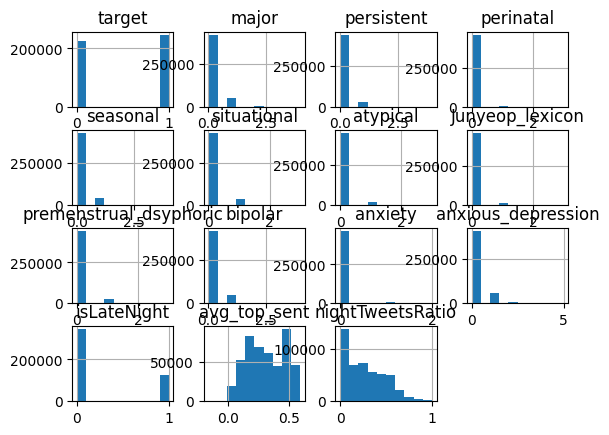

In [ ]:
aug_big_df.hist()

In [ ]:
cols = ['major', 'persistent', 'perinatal', 'seasonal', 'situational',
       'atypical', 'Junyeop_lexicon', 'premenstrual_dsyphoric', 'bipolar',
       'anxiety', 'anxious_depression', 'isLateNight', 'avg_top_sent',
       'nightTweetsRatio']

correlation_dict = {}

# Get correlations and store them in the dictionary
for col in cols:
    correlation_dict[col] = abs(aug_big_df["target"].corr(aug_big_df[col]))

# Convert the dictionary to a DataFrame for nice tabular format
correlation_df = pd.DataFrame(list(correlation_dict.items()), columns=['Feature', 'Correlation with Target'])

# Print the DataFrame
correlation_df.head(30)

Feature  Correlation with Target
0                    major                 0.121776
1               persistent                 0.124182
2                perinatal                 0.095339
3                 seasonal                 0.129904
4              situational                 0.003334
5                 atypical                 0.070286
6          Junyeop_lexicon                 0.130512
7   premenstrual_dsyphoric                 0.100702
8                  bipolar                 0.108781
9                  anxiety                 0.025247
10      anxious_depression                 0.230151
11             isLateNight                 0.080536
12            avg_top_sent                 0.256260
13        nightTweetsRatio                 0.088534

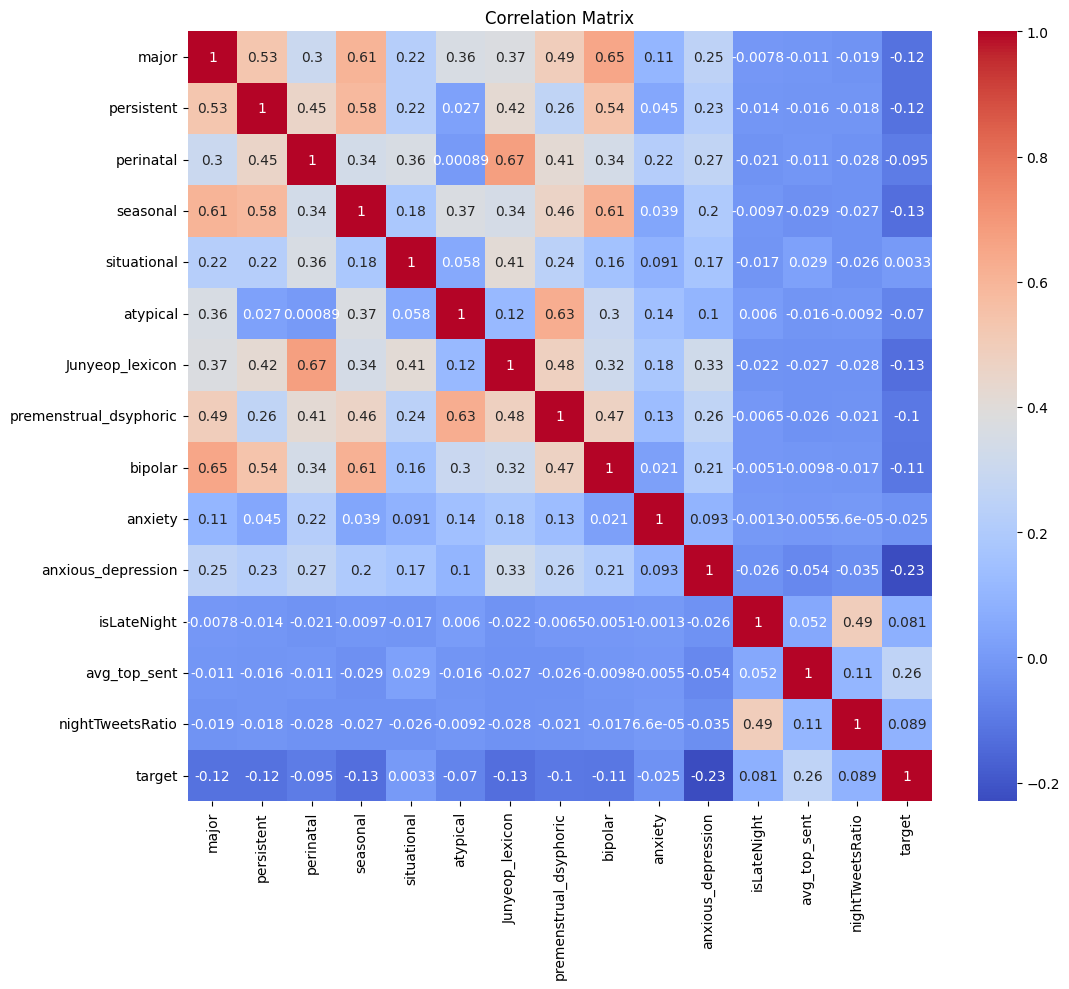

In [ ]:
# Target variable

subset_df = aug_big_df[cols + ['target']]
correlation_matrix = subset_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [ ]:
## save the augmented dataset
aug_big_df.to_csv("pre-processed data/cln_aug_big_sentiment140_full_lex.csv")

# ML classification

In [5]:
%pip install xgboost bayesian-optimization

Note: you may need to restart the kernel to use updated packages.


In [1]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization
from sklearn.metrics import accuracy_score
from xgboost import XGBClassifier
import matplotlib.pyplot as plt
from scipy.sparse import hstack
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
import seaborn as sns
import pandas as pd
import numpy as np
import time

In [2]:
import nltk
from nltk import word_tokenize, pos_tag
from collections import Counter
import pandas as pd

# nltk.download()
# nltk.download('stopwords')
# nltk.download('punkt') # For tokenization
# nltk.download('averaged_perceptron_tagger') # For POS tagging

## Train & Test

In [3]:
# # Local:
df = pd.read_csv("pre-processed data/cln_aug_big_sentiment140_full_lex.csv", encoding='latin-1')

# Google Colab:
# df = pd.read_csv("/content/drive/MyDrive/Saleh's PhD/pre-processed data/cln_aug_big_sentiment140_full_lex.csv", encoding='latin-1')

print("Dataset shape:", df.shape)
print("Total number of unique users: ", len(df.user.unique()))
df.drop(["Unnamed: 0","date","user"], axis= 1, inplace= True)
df.head(2)

Dataset shape: (468272, 20)
Total number of unique users:  27069


target                                               text  \
0       0  Panera Bread's internet access is LAME   It bl...   
1       0  @NaniWaialeale No, not Keith Olbermann, he ann...   

                                         cleaned_txt  major  persistent  \
0  panera bread internet access lame block twitte...      0           0   
1  no not keith olbermann annoy anyhow hit hey co...      0           0   

   perinatal  seasonal  situational  atypical  Junyeop_lexicon  \
0          0         0            0         0                0   
1          0         0            0         0                0   

   premenstrual_dsyphoric  bipolar  anxiety  anxious_depression  isLateNight  \
0                       0        0        0                   0            0   
1                       0        0        0                   0            0   

   avg_top_sent  nightTweetsRatio  
0          0.31              0.05  
1          0.31              0.05

In [ ]:
import nltk
from nltk.corpus import stopwords
import string
import re 

def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # Remove numbers using regex
    text = re.sub(r'\d+', '', text)  # Corrected line
    
    # Tokenize by splitting the text
    tokens = text.split()
    
    # Optionally, remove stop words
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # This returns the tokens, if you prefer a string, join them back
    return ' '.join(tokens)

# Apply the preprocessing function to each row in the raw text column
df['text'] = df['text'].apply(preprocess_text)

In [6]:
column_mapping = {
    'premenstrual_dsyphoric': 'premenstrual',
    'Junyeop_lexicon': 'Junyeop_lex',
    'anxious_depression': 'anxious_dep',
    'nightTweetsRatio': 'night_ratio'
}

# Renaming columns
df.rename(columns=column_mapping, inplace=True)

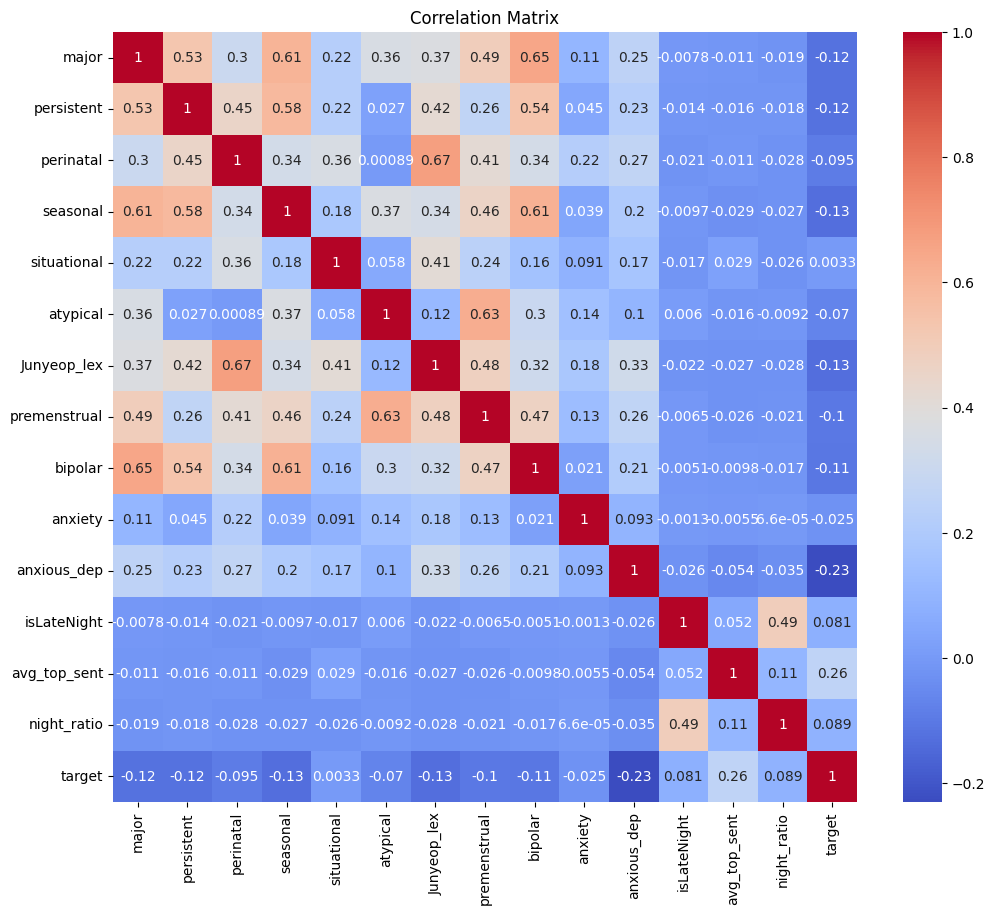

In [ ]:
# Target variable

cols = ['major', 'persistent', 'perinatal', 'seasonal', 'situational',
       'atypical', 'Junyeop_lex', 'premenstrual', 'bipolar',
       'anxiety', 'anxious_dep', 'isLateNight', 'avg_top_sent',
       'night_ratio']


subset_df = df[cols + ['target']]

correlation_matrix = subset_df.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig("correlation matrix.pdf",   bbox_inches="tight")
plt.show()

In [7]:
target_col = "target"
text_col = "cleaned_txt"
# text_col = "text"
numerical_cols = ['major', 'persistent', 'perinatal', 'seasonal', 'situational',
                  'atypical', 'Junyeop_lex', 'premenstrual', 'bipolar',
                  'anxiety', 'anxious_dep', 'isLateNight']
profiling_cols = ['avg_top_sent', 'night_ratio']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(df.drop([target_col, text_col], axis=1), df[target_col], test_size=0.2, random_state=42)

POS tagging:

In [9]:
def pos_tag_texts(df, text_col):
    # Apply POS tagging
    pos_tagged_texts = df[text_col].apply(nltk.word_tokenize).apply(nltk.pos_tag)

    # Expand the DataFrame to store the counts/ratios of more POS categories
    additional_tags = ['pronoun_count', 'determiner_count', 'conjunction_count', 'preposition_count', 'modal_count', 'ratio_nouns_verbs']
    all_tags = ['noun_count', 'adjective_count', 'verb_count', 'adverb_count', 'unknown_tags_count'] + additional_tags
    pos_counts_df = pd.DataFrame(index=df.index, columns=all_tags).fillna(0)

    # Define more POS tags
    pronoun_tags = {'PRP', 'PRP$', 'WP', 'WP$'}
    determiner_tags = {'DT', 'PDT', 'WDT'}
    conjunction_tags = {'CC'}
    preposition_tags = {'IN'}
    modal_tags = {'MD'}

    for index, tagged_text in pos_tagged_texts.iteritems():
        tag_counts = Counter(tag for _, tag in tagged_text)
        total_tags = sum(tag_counts.values())

        # Update counts for each POS category
        for tag in pronoun_tags: pos_counts_df.at[index, 'pronoun_count'] += tag_counts.get(tag, 0)
        for tag in determiner_tags: pos_counts_df.at[index, 'determiner_count'] += tag_counts.get(tag, 0)
        for tag in conjunction_tags: pos_counts_df.at[index, 'conjunction_count'] += tag_counts.get(tag, 0)
        for tag in preposition_tags: pos_counts_df.at[index, 'preposition_count'] += tag_counts.get(tag, 0)
        for tag in modal_tags: pos_counts_df.at[index, 'modal_count'] += tag_counts.get(tag, 0)

        # Original counts
        pos_counts_df.at[index, 'noun_count'] = sum(tag_counts[tag] for tag in {'NN', 'NNS', 'NNP', 'NNPS'})
        pos_counts_df.at[index, 'adjective_count'] = sum(tag_counts[tag] for tag in {'JJ', 'JJR', 'JJS'})
        pos_counts_df.at[index, 'verb_count'] = sum(tag_counts[tag] for tag in {'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ'})
        pos_counts_df.at[index, 'adverb_count'] = sum(tag_counts[tag] for tag in {'RB', 'RBR', 'RBS'})

        # Compute unknown tags by excluding known tags
        known_tags = pronoun_tags | determiner_tags | conjunction_tags | preposition_tags | modal_tags | {'NN', 'NNS', 'NNP', 'NNPS', 'JJ', 'JJR', 'JJS', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'RB', 'RBR', 'RBS'}
        pos_counts_df.at[index, 'unknown_tags_count'] = sum(tag_counts[tag] for tag in tag_counts if tag not in known_tags)

        # Compute ratios or other meaningful metrics
        noun_count = pos_counts_df.at[index, 'noun_count']
        verb_count = pos_counts_df.at[index, 'verb_count']
        if total_tags > 0:
            pos_counts_df.at[index, 'ratio_nouns_verbs'] = noun_count / float(verb_count) if verb_count > 0 else noun_count

    return pos_counts_df


# Apply the updated POS tagging to training and testing sets
X_train_pos = pos_tag_texts(df.loc[X_train.index], text_col)
X_test_pos = pos_tag_texts(df.loc[X_test.index], text_col)


In [10]:
print(len(X_train_pos.columns))

11


N-gram

In [11]:
X_train_pos.head(3)

noun_count  adjective_count  verb_count  adverb_count  \
100439           3                1           0             0   
313092           1                1           1             1   
110327           2                1           1             0   

        unknown_tags_count  pronoun_count  determiner_count  \
100439                   0              0                 0   
313092                   0              0                 0   
110327                   0              0                 0   

        conjunction_count  preposition_count  modal_count  ratio_nouns_verbs  
100439                  0                  0            0                  3  
313092                  0                  0            0                  1  
110327                  0                  0            0                  2

In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Adjust ngram_range according to your preference (e.g., (2, 4) for bi-grams to four-grams)
tfidf_char_ngram = TfidfVectorizer(analyzer='char', ngram_range=(2, 4), max_features=300)

# Fit and transform the training data
X_train_char_ngram = tfidf_char_ngram.fit_transform(df.loc[X_train.index, text_col])

# Transform the testing data
X_test_char_ngram = tfidf_char_ngram.transform(df.loc[X_test.index, text_col])

# Get feature names (character n-grams)
tokens_char_ngram = tfidf_char_ngram.get_feature_names_out()

# Add prefix to the feature names that exist in the X_train columns
# This step may be adjusted based on the uniqueness of n-gram feature names
new_col_names_char_ngram = ['char_ngram_'+name if name in X_train.columns else name for name in tokens_char_ngram]

# Convert the sparse matrices to DataFrames for easier handling
X_train_char_ngram = pd.DataFrame(X_train_char_ngram.toarray(), columns=new_col_names_char_ngram, index=X_train.index)
X_test_char_ngram = pd.DataFrame(X_test_char_ngram.toarray(), columns=new_col_names_char_ngram, index=X_test.index)


In [13]:
X_train_char_ngram.head(3)

a         b       ba    c   ca   co         d        da    e  \
100439  0.0  0.000000  0.00000  0.0  0.0  0.0  0.000000  0.000000  0.0   
313092  0.0  0.150664  0.22859  0.0  0.0  0.0  0.164815  0.225998  0.0   
110327  0.0  0.000000  0.00000  0.0  0.0  0.0  0.000000  0.000000  0.0   

               f  ...   w         wa   we   wi   wo  wor   y   y s        ye  \
100439  0.000000  ...  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.404321   
313092  0.000000  ...  0.0  0.182173  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   
110327  0.168168  ...  0.0  0.000000  0.0  0.0  0.0  0.0  0.0  0.0  0.000000   

         yo  
100439  0.0  
313092  0.0  
110327  0.0  

[3 rows x 300 columns]

Word2Vec:

In [14]:
from gensim.models import KeyedVectors

# Load Google's pre-trained Word2Vec model.
word2vec_model = KeyedVectors.load_word2vec_format('utils\GoogleNews-vectors-negative300.bin', binary=True)


In [15]:
import numpy as np

def document_vector(doc):
    # Remove out-of-vocabulary words.
    doc = [word for word in doc if word in word2vec_model.key_to_index]
    if len(doc) == 0:
        return np.zeros(word2vec_model.vector_size)
    # Average the word vectors for a document.
    return np.mean(word2vec_model[doc], axis=0)

X_train_w2v = np.array([document_vector(doc) for doc in df.loc[X_train.index, text_col]])
X_test_w2v = np.array([document_vector(doc) for doc in df.loc[X_test.index, text_col]])

X_train_w2v_df = pd.DataFrame(X_train_w2v, index=X_train.index)
X_test_w2v_df = pd.DataFrame(X_test_w2v, index=X_test.index)


In [18]:
X_train_w2v_df.head(2)

0         1         2         3         4         5         6    \
100439 -0.144287  0.180094 -0.013298  0.107552 -0.075277  0.031466 -0.121482   
313092 -0.126933  0.072301  0.072968  0.164368  0.006121  0.031535 -0.106364   

             7         8         9    ...       290       291       292  \
100439 -0.023372 -0.068844  0.035824  ...  0.084196 -0.064705 -0.121653   
313092 -0.092936 -0.047689 -0.025386  ...  0.069987 -0.028849 -0.050905   

             293       294       295       296       297       298       299  
100439  0.096419  0.024284 -0.114714 -0.098649 -0.036938 -0.139600  0.169287  
313092  0.205973 -0.039205 -0.143392 -0.107747 -0.020610 -0.105062  0.174194  

[2 rows x 300 columns]

TF-IDF vectorizing:

In [16]:
tfidf = TfidfVectorizer(max_features = 300)
X_train_tfidf = tfidf.fit_transform(df.loc[X_train.index, text_col])
X_test_tfidf = tfidf.transform(df.loc[X_test.index, text_col])

tokens = tfidf.get_feature_names_out()

# Add prefix to the feature names that exist in the X_train columns
new_col_names = ['tfidf_'+name if name in X_train.columns else name for name in tokens]

# Text-only (Convert the sparse matrix to DataFrame)
X_train_tfidf_df = pd.DataFrame(X_train_tfidf.toarray(), columns=new_col_names, index=X_train.index)
X_test_tfidf_df = pd.DataFrame(X_test_tfidf.toarray(), columns=new_col_names, index=X_test.index)


In [17]:
# Tabular only (excluding TF-IDF)
X_train_num_pro = pd.concat([X_train[numerical_cols], X_train[profiling_cols]], axis=1)
X_test_num_pro = pd.concat([X_test[numerical_cols], X_test[profiling_cols]], axis=1)

# ALL
X_train_all = pd.concat([X_train_tfidf_df, X_train[numerical_cols + profiling_cols]], axis=1)
X_test_all = pd.concat([X_test_tfidf_df, X_test[numerical_cols + profiling_cols]], axis=1)


In [18]:
X_train_tfidf_df.head(2)

actually  add   ah  almost  already  also  always  amaze  another  \
100439       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   
313092       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   

        anyone  ...  write  wrong   xx   ya  yay      yeah  year  yes  \
100439     0.0  ...    0.0    0.0  0.0  0.0  0.0  0.836773   0.0  0.0   
313092     0.0  ...    0.0    0.0  0.0  0.0  0.0  0.000000   0.0  0.0   

        yesterday  yet  
100439        0.0  0.0  
313092        0.0  0.0  

[2 rows x 300 columns]

In [19]:
X_train_all.head(2)

actually  add   ah  almost  already  also  always  amaze  another  \
100439       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   
313092       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   

        anyone  ...  situational  atypical  Junyeop_lex  premenstrual  \
100439     0.0  ...            0         0            0             0   
313092     0.0  ...            0         0            0             0   

        bipolar  anxiety  anxious_dep  isLateNight  avg_top_sent  night_ratio  
100439        0        0            0            0          0.43         0.00  
313092        0        0            0            1          0.22         0.42  

[2 rows x 314 columns]

In [23]:
print(len(X_train_tfidf_df.columns))
print(len(X_train_all.columns))

300
314


In [20]:
scoring = ['accuracy', 'precision', 'recall', 'f1']

In [21]:
### Result of the hyperparameter tuning
from sklearn.naive_bayes import GaussianNB

xgb_best_params ={
    'colsample_bytree': 0.62,
    'gamma': 1.83,
    'learning_rate': 0.25,
    'max_depth': 10,
    'min_child_weight': 6,
    'n_estimators': 132,
    'reg_alpha': 0.99,
    'reg_lambda': 0.51,
    'subsample': 0.94
    }

# Defining the models

svm = SVC()
nb = GaussianNB()
dt = DecisionTreeClassifier(random_state=123, criterion='gini')
xgb = XGBClassifier(random_state=123, **xgb_best_params)

models = [svm, nb, dt, xgb]

POS-only:

In [22]:
# Train and evaluate each model
for model in models:
    scores = cross_validate(model, X_train_pos, y_train, scoring=scoring, cv=3, return_train_score=False)

    # Print evaluation metrics
    for metric in scoring:
        average_score = np.mean(scores['test_'+metric])
        std_dev_score = np.std(scores['test_'+metric])
        print(f"{model.__class__.__name__} avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

    # Train model
    model.fit(X_train_pos, y_train)

    # Make predictions
    y_pred = model.predict(X_test_pos)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))

Character n-gram:

In [ ]:

# Train and evaluate each model
for model in models:
    scores = cross_validate(model, X_train_char_ngram, y_train, scoring=scoring, cv=3, return_train_score=False)

    # Print evaluation metrics
    for metric in scoring:
        average_score = np.mean(scores['test_'+metric])
        std_dev_score = np.std(scores['test_'+metric])
        print(f"{model.__class__.__name__} avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

    # Train model
    model.fit(X_train_char_ngram, y_train)

    # Make predictions
    y_pred = model.predict(X_test_char_ngram)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))


MultinomialNB avg accuracy: 0.66 (+- 0.001)
MultinomialNB avg precision: 0.66 (+- 0.001)
MultinomialNB avg recall: 0.71 (+- 0.002)
MultinomialNB avg f1: 0.68 (+- 0.001)
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.65      0.60      0.63     44676
           1       0.66      0.71      0.69     48979

    accuracy                           0.66     93655
   macro avg       0.66      0.66      0.66     93655
weighted avg       0.66      0.66      0.66     93655

DecisionTreeClassifier avg accuracy: 0.63 (+- 0.001)
DecisionTreeClassifier avg precision: 0.65 (+- 0.001)
DecisionTreeClassifier avg recall: 0.64 (+- 0.002)
DecisionTreeClassifier avg f1: 0.65 (+- 0.001)
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.62      0.62      0.62     44676
           1       0.65      0.65      0.65     48979

    accuracy                           0.63 

Tabular-Only:

In [73]:
# Train and evaluate each model
for model in models:
    scores = cross_validate(model, X_train_num_pro, y_train, scoring=scoring, cv=3, return_train_score=False)

    # Print evaluation metrics
    for metric in scoring:
        average_score = np.mean(scores['test_'+metric])
        std_dev_score = np.std(scores['test_'+metric])
        print(f"{model.__class__.__name__} avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

    # Train model
    model.fit(X_train_num_pro, y_train)

    # Make predictions
    y_pred = model.predict(X_test_num_pro)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))

DecisionTreeClassifier avg accuracy: 0.65 (+- 0.002)
DecisionTreeClassifier avg precision: 0.66 (+- 0.0)
DecisionTreeClassifier avg recall: 0.7 (+- 0.006)
DecisionTreeClassifier avg f1: 0.68 (+- 0.003)
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.66      0.59      0.62     44676
           1       0.66      0.72      0.69     48979

    accuracy                           0.66     93655
   macro avg       0.66      0.65      0.65     93655
weighted avg       0.66      0.66      0.66     93655

XGBClassifier avg accuracy: 0.67 (+- 0.001)
XGBClassifier avg precision: 0.66 (+- 0.002)
XGBClassifier avg recall: 0.79 (+- 0.004)
XGBClassifier avg f1: 0.71 (+- 0.001)
Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.70      0.55      0.61     44676
           1       0.66      0.79      0.71     48979

    accuracy                           0.67    

In [77]:
# from sklearn.naive_bayes import GaussianNB

# # Initialize GaussianNB
# gnb_model = GaussianNB()


# # Use cross_validate to evaluate the model
# scores = cross_validate(gnb_model, X_train_num_pro, y_train, scoring=scoring, cv=3, return_train_score=False)

# # Iterate through each metric to print the average score and standard deviation
# for metric in scoring:
#     average_score = np.mean(scores['test_'+metric])
#     std_dev_score = np.std(scores['test_'+metric])
#     print(f"Text-Tabular Model with GaussianNB avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

# # Fit the pipeline on the training data
# gnb_model.fit(X_train_num_pro, y_train)

# # Predict on the test data
# y_pred = gnb_model.predict(X_test_num_pro)

# # Print the classification report
# print(classification_report(y_test, y_pred))


Text-Tabular Model with GaussianNB avg accuracy: 0.6 (+- 0.0)
Text-Tabular Model with GaussianNB avg precision: 0.58 (+- 0.0)
Text-Tabular Model with GaussianNB avg recall: 0.89 (+- 0.002)
Text-Tabular Model with GaussianNB avg f1: 0.7 (+- 0.001)
              precision    recall  f1-score   support

           0       0.70      0.29      0.41     44676
           1       0.58      0.89      0.70     48979

    accuracy                           0.60     93655
   macro avg       0.64      0.59      0.55     93655
weighted avg       0.64      0.60      0.56     93655



Word2Vec:

In [ ]:
# Train and evaluate each model
for model in models:
    scores = cross_validate(model, X_train_w2v_df, y_train, scoring=scoring, cv=3, return_train_score=False)

    # Print evaluation metrics
    for metric in scoring:
        average_score = np.mean(scores['test_'+metric])
        std_dev_score = np.std(scores['test_'+metric])
        print(f"{model.__class__.__name__} avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

    # Train model
    model.fit(X_train_w2v_df, y_train)

    # Make predictions
    y_pred = model.predict(X_test_w2v_df)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))



In [92]:
# Initialize GaussianNB
gnb_model = GaussianNB()

scores = cross_validate(gnb_model, X_train_w2v_df, y_train, scoring=scoring, cv=3, return_train_score=False)

# Iterate through each metric to print the average score and standard deviation
for metric in scoring:
    average_score = np.mean(scores['test_'+metric])
    std_dev_score = np.std(scores['test_'+metric])
    print(f"Word2Vec with NB avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

gnb_model.fit(X_train_w2v_df, y_train)

y_pred = gnb_model.predict(X_test_w2v_df)

print(classification_report(y_test, y_pred))

Word2Vec with NB avg accuracy: 0.54 (+- 0.002)
Word2Vec with NB avg precision: 0.6 (+- 0.004)
Word2Vec with NB avg recall: 0.36 (+- 0.004)
Word2Vec with NB avg f1: 0.45 (+- 0.004)
              precision    recall  f1-score   support

           0       0.51      0.74      0.60     44676
           1       0.60      0.36      0.45     48979

    accuracy                           0.54     93655
   macro avg       0.56      0.55      0.53     93655
weighted avg       0.56      0.54      0.52     93655



TF-IDF-only

In [74]:
# Train and evaluate each model
for model in models:
    scores = cross_validate(model, X_train_tfidf, y_train, scoring=scoring, cv=3, return_train_score=False)

    # Print evaluation metrics
    for metric in scoring:
        average_score = np.mean(scores['test_'+metric])
        std_dev_score = np.std(scores['test_'+metric])
        print(f"{model.__class__.__name__} avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

    # Train model
    model.fit(X_train_tfidf, y_train)

    # Make predictions
    y_pred = model.predict(X_test_tfidf)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))


MultinomialNB avg accuracy: 0.72 (+- 0.001)
MultinomialNB avg precision: 0.72 (+- 0.001)
MultinomialNB avg recall: 0.76 (+- 0.0)
MultinomialNB avg f1: 0.74 (+- 0.001)
Classification Report for MultinomialNB:
              precision    recall  f1-score   support

           0       0.72      0.67      0.70     44676
           1       0.72      0.77      0.74     48979

    accuracy                           0.72     93655
   macro avg       0.72      0.72      0.72     93655
weighted avg       0.72      0.72      0.72     93655

DecisionTreeClassifier avg accuracy: 0.68 (+- 0.0)
DecisionTreeClassifier avg precision: 0.69 (+- 0.0)
DecisionTreeClassifier avg recall: 0.71 (+- 0.001)
DecisionTreeClassifier avg f1: 0.7 (+- 0.0)
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.68      0.65      0.66     44676
           1       0.69      0.72      0.70     48979

    accuracy                           0.68     93655

Text-Tabular

In [ ]:
# Train and evaluate each model
for model in models[1:]:
    scores = cross_validate(model, X_train_all, y_train, scoring=scoring, cv=3, return_train_score=False)

    # Print evaluation metrics
    for metric in scoring:
        average_score = np.mean(scores['test_'+metric])
        std_dev_score = np.std(scores['test_'+metric])
        print(f"{model.__class__.__name__} avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

    # Train model
    model.fit(X_train_all, y_train)

    # Make predictions
    y_pred = model.predict(X_test_all)

    # Print classification report
    print(f"Classification Report for {model.__class__.__name__}:")
    print(classification_report(y_test, y_pred))


DecisionTreeClassifier avg accuracy: 0.68 (+- 0.0)
DecisionTreeClassifier avg precision: 0.7 (+- 0.001)
DecisionTreeClassifier avg recall: 0.68 (+- 0.001)
DecisionTreeClassifier avg f1: 0.69 (+- 0.0)
Classification Report for DecisionTreeClassifier:
              precision    recall  f1-score   support

           0       0.66      0.68      0.67     44676
           1       0.70      0.69      0.69     48979

    accuracy                           0.68     93655
   macro avg       0.68      0.68      0.68     93655
weighted avg       0.68      0.68      0.68     93655

XGBClassifier avg accuracy: 0.76 (+- 0.001)
XGBClassifier avg precision: 0.76 (+- 0.0)
XGBClassifier avg recall: 0.79 (+- 0.002)
XGBClassifier avg f1: 0.78 (+- 0.001)
Classification Report for XGBClassifier:
              precision    recall  f1-score   support

           0       0.76      0.73      0.75     44676
           1       0.76      0.80      0.78     48979

    accuracy                           0.76     936

In [76]:
from sklearn.naive_bayes import GaussianNB

# Initialize GaussianNB
gnb_model = GaussianNB()


# Use cross_validate to evaluate the model
scores = cross_validate(gnb_model, X_train_all, y_train, scoring=scoring, cv=3, return_train_score=False)

# Iterate through each metric to print the average score and standard deviation
for metric in scoring:
    average_score = np.mean(scores['test_'+metric])
    std_dev_score = np.std(scores['test_'+metric])
    print(f"Text-Tabular Model with GaussianNB avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

# Fit the pipeline on the training data
gnb_model.fit(X_train_all, y_train)

# Predict on the test data
y_pred = gnb_model.predict(X_test_all)

# Print the classification report
print(classification_report(y_test, y_pred))


Text-Tabular Model with GaussianNB avg accuracy: 0.7 (+- 0.002)
Text-Tabular Model with GaussianNB avg precision: 0.71 (+- 0.002)
Text-Tabular Model with GaussianNB avg recall: 0.73 (+- 0.0)
Text-Tabular Model with GaussianNB avg f1: 0.72 (+- 0.001)
              precision    recall  f1-score   support

           0       0.70      0.68      0.69     44676
           1       0.71      0.73      0.72     48979

    accuracy                           0.70     93655
   macro avg       0.70      0.70      0.70     93655
weighted avg       0.70      0.70      0.70     93655



In [ ]:
# xgb3 = XGBClassifier(random_state=123, **xgb_best_params)
# scores3 = cross_validate(xgb3, X_train_all, y_train, scoring=scoring, cv = 3, return_train_score=False)

# for metric in scoring:
#     average_score = np.mean(scores3['test_'+metric])
#     std_dev_score = np.std(scores3['test_'+metric])
#     print(f"Text-Tabular Model avg {metric}: {round(average_score, 2)} (+- {round(std_dev_score, 3)})")

# xgb3.fit(X_train_all, y_train)
# y_pred3 = xgb3.predict(X_test_all)
# print(classification_report(y_test, y_pred3))


## Hyper-parameter tuning

For XGboost classifier

In [ ]:
# XGBoost Classifier
def xgb_cl_bo(max_depth, gamma, learning_rate, n_estimators, subsample, min_child_weight, reg_lambda, reg_alpha, colsample_bytree):
    params_xgb = {}
    params_xgb['max_depth'] = int(max_depth)
    params_xgb['gamma'] = gamma
    params_xgb['learning_rate'] = learning_rate
    params_xgb['n_estimators'] = int(n_estimators)
    params_xgb['subsample'] = subsample
    params_xgb['min_child_weight'] = int(min_child_weight)
    params_xgb['reg_lambda'] = reg_lambda
    params_xgb['reg_alpha'] = reg_alpha
    params_xgb['colsample_bytree'] = colsample_bytree

    scores = cross_val_score(XGBClassifier(random_state=123, **params_xgb),
                             X_train_all, y_train, scoring='accuracy', cv = 7).mean()
    score = scores.mean()
    return score

# Initialize lists to store accuracy and iteration values
accuracy_values = []
iteration_values = []

# Run Bayesian Optimization
start = time.time()
params_xgb ={
    'max_depth': (2, 12),
    'gamma': (0, 5),
    'learning_rate': (0.01, 1),
    'n_estimators': (80, 200),
    'subsample': (0.5, 1),
    'min_child_weight': (1, 10),
    'reg_lambda': (0, 1),
    'reg_alpha': (0, 1),
    'colsample_bytree': (0.5, 1)
}

xgb_bo = BayesianOptimization(xgb_cl_bo, params_xgb, random_state=111)
xgb_bo.maximize(init_points = 15, n_iter = 5)

print('It takes %s minutes' % ((time.time() - start) / 60))

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_alpha | reg_la... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.7561    | 0.8061    | 0.8453    | 0.4417    | 9.693     | 3.658     | 97.9      | 0.02248   | 0.4202    | 0.6193    |
| 2         | 0.7438    | 0.6688    | 4.954     | 0.2453    | 2.812     | 7.026     | 154.5     | 0.2743    | 0.4662    | 0.5592    |
| 3         | 0.7518    | 0.537     | 4.504     | 0.796     | 10.41     | 8.337     | 198.9     | 0.5773    | 0.8138    | 0.7107    |
| 4         | 0.7583    | 0.5137    | 2.271     | 0.1143    | 10.17     | 7.28      | 147.8     | 0.2742    | 0.9985    | 0.569     |
| 5         | 0.7598    | 0.8077    | 2.425     | 0.411     | 9.278     | 3.905     | 128.1     | 0.319     | 0.9472    | 0.9594    |
| 6         | 0.7426    | 0.9069    | 0.1704    | 0.9439    | 

In [ ]:
# Access the best parameters and print them
xgb_best_params = xgb_bo.max['params']
print("XGB Best Parameters:")
xgb_best_params

XGB Best Parameters:


{'colsample_bytree': 0.6229261253925649,
 'gamma': 1.8340140886821132,
 'learning_rate': 0.24939739928659224,
 'max_depth': 10.565421423132696,
 'min_child_weight': 6.62949585020837,
 'n_estimators': 131.78766005292772,
 'reg_alpha': 0.9957394202185132,
 'reg_lambda': 0.5167878855688456,
 'subsample': 0.9377718790293641}

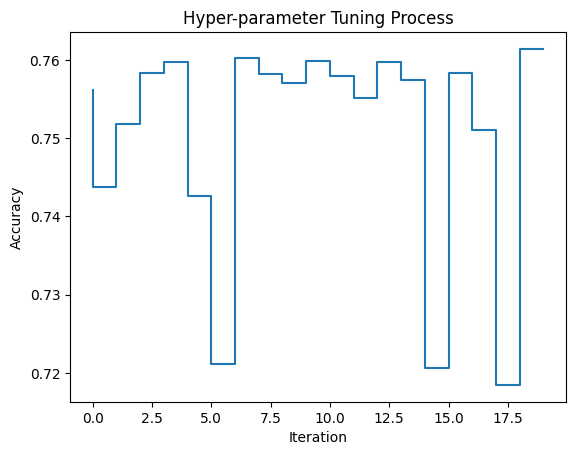

In [ ]:
# Plot the hyper-parameter tuning process
x_iters = list(range(len(xgb_bo.res)))
y_iters = [res['target'] for res in xgb_bo.res]
plt.step(x_iters, y_iters)
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.title("Hyper-parameter Tuning Process")
plt.show()

In [ ]:
xgb_best_params ={
    'colsample_bytree': 0.62,
    'gamma': 1.83,
    'learning_rate': 0.25,
    'max_depth': 10,
    'min_child_weight': 6,
    'n_estimators': 132,
    'reg_alpha': 0.99,
    'reg_lambda': 0.51,
    'subsample': 0.94
    }

## SHAP value plots

In [ ]:
# # %pip install numpy==1.24
# %pip install shap
# # %pip install --upgrade numpy numba

In [ ]:
import sklearn
import numpy
import shap

print("sklearn version:", sklearn.__version__)
print("numpy version:", numpy.__version__)
print("shap version:", shap.__version__)

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


sklearn version: 1.3.0
numpy version: 1.24.4
shap version: 0.42.1


In [ ]:
feat_names =  list(new_col_names) + numerical_cols + profiling_cols
feat_names[:10]

['actually',
 'add',
 'ah',
 'almost',
 'already',
 'also',
 'always',
 'amaze',
 'another',
 'anyone']

In [ ]:
# ind1 = feat_names.index("anxious_depression")
# feat_names[ind1] = "anxiousDep"

# ind2 = feat_names.index("nightTweetsRatio")
# feat_names[ind2] = "nightRatio"

In [ ]:
X_train.head()

major  persistent  perinatal  seasonal  situational  atypical  \
100439      0           0          0         0            0         0   
313092      0           0          0         0            0         0   
110327      0           0          0         0            0         0   
140715      0           0          0         0            1         0   
264178      0           0          0         0            0         0   

        Junyeop_lex  premenstrual  bipolar  anxiety  anxious_dep  isLateNight  \
100439            0             0        0        0            0            0   
313092            0             0        0        0            0            1   
110327            0             0        0        0            0            0   
140715            0             0        0        0            0            0   
264178            0             0        0        0            0            0   

        avg_top_sent  night_ratio  
100439          0.43         0.00  
313092          0.22         0.42  
110327          0.34         0.02  
140715          0.34         0.08  
264178          0.08         0.33

In [ ]:
X_train_all.head()

actually  add   ah  almost  already  also  always  amaze  another  \
100439       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   
313092       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   
110327       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   
140715       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   
264178       0.0  0.0  0.0     0.0      0.0   0.0     0.0    0.0      0.0   

        anyone  ...  situational  atypical  Junyeop_lex  premenstrual  \
100439     0.0  ...            0         0            0             0   
313092     0.0  ...            0         0            0             0   
110327     0.0  ...            0         0            0             0   
140715     0.0  ...            1         0            0             0   
264178     0.0  ...            0         0            0             0   

        bipolar  anxiety  anxious_dep  isLateNight  avg_top_sent  night_ratio  
100439        0        0            0            0          0.43         0.00  
313092        0        0            0            1          0.22         0.42  
110327        0        0            0            0          0.34         0.02  
140715        0        0            0            0          0.34         0.08  
264178        0        0            0            0          0.08         0.33  

[5 rows x 314 columns]

In [ ]:
dir = './pre-processed data/'

X_train_all.to_csv(dir + 'X_train_all.csv', encoding='latin-1', index= False)
y_train.to_csv(dir + 'y_train.csv', encoding='latin-1', index= False)

X_test_all.to_csv(dir + 'X_test_all.csv', encoding='latin-1', index= False)
y_test.to_csv(dir + 'y_test.csv', encoding='latin-1', index= False)


In [ ]:
explainer = shap.TreeExplainer(tuned_xgb)
shap_values = explainer.shap_values(X_test_all)

shap_test = explainer(X_test_all)
shape_train = explainer(X_train_all)

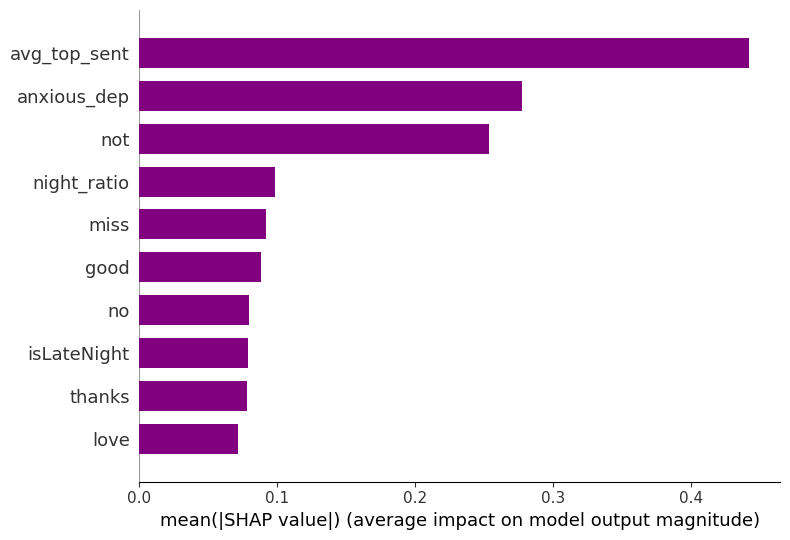

In [ ]:
shap.initjs()
# plot the SHAP values
shap.summary_plot(shap_test, X_train_all, plot_type="bar",  max_display=10, feature_names = feat_names, color = "purple", show=False)

# Step 4: Save the plot as a PDF file
plt.savefig("shap_summary_plot_test.pdf")
plt.show()

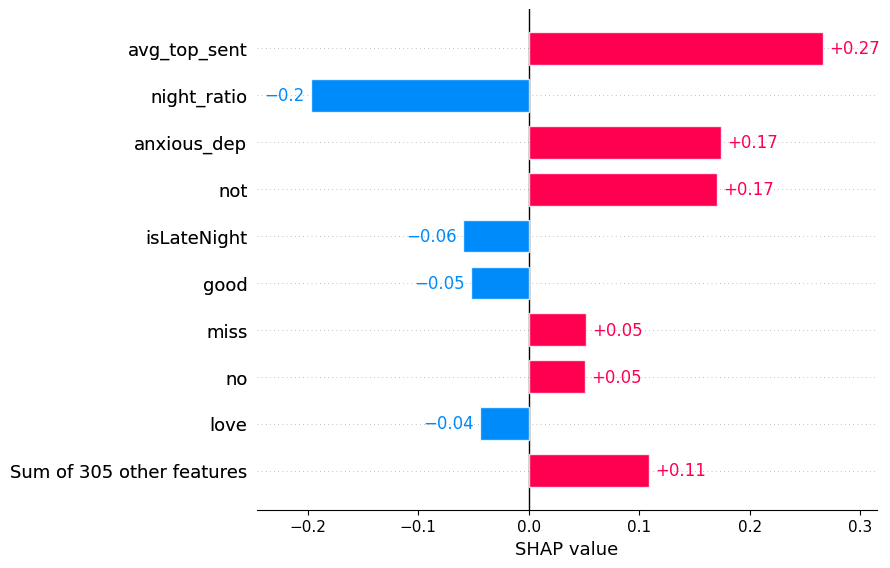

In [ ]:
shap.plots.bar(shap_test[53], show=False)

plt.savefig("shap_bar_plot11.pdf",  bbox_inches="tight")
plt.show()

In [ ]:
import numpy as np
SAMPLE_SIZE = 800

# Randomly select samples
random_indices = np.random.choice(shap_values.shape[0], size = SAMPLE_SIZE, replace=False)

# Select the SHAP values for these samples
shap_values_sample = shap_values[random_indices]

# shap.initjs()
# Create the SHAP force plot for these samples
shap.force_plot(explainer.expected_value, shap_values_sample, feature_names= feat_names)